In [1]:
import os
from dotenv import load_dotenv

load_dotenv()  # Load from .env file

api_key = os.getenv("TAVILY_API_KEY")

print("API key loaded:", api_key[:4] + "..." if api_key else "Not found")

API key loaded: tvly...


Define the Tool

In [2]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': "Introduction to LangGraph: A Beginner's Guide - Medium",
   'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
   'content': 'Stateful Graph: LangGraph revolves around the concept of a stateful graph, where each node in the graph represents a step in your computation, and the graph maintains a state that is passed around and updated as the computation progresses. LangGraph supports conditional edges, allowing you to dynamically determine the next node to execute based on the current state of the graph. We define nodes for classifying the input, handling greetings, and handling search queries. def classify_input_node(state): LangGraph is a versatile tool for building complex, stateful applications with LLMs. By understanding its core concepts and working through simple examples, beginners can start to leverage its powe

Define the graph

In [3]:
from langchain.chat_models import init_chat_model # type: ignore

# Follow the steps here to configure your credentials:
# https://docs.aws.amazon.com/bedrock/latest/userguide/getting-started.html

llm = init_chat_model(
    "anthropic.claude-3-haiku-20240307-v1:0",
    model_provider="bedrock_converse",
)

from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Modification: tell the LLM which tools it can call
# highlight-next-line
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

Create a function to run the tools

In [4]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

Define the conditional_edges

In [5]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

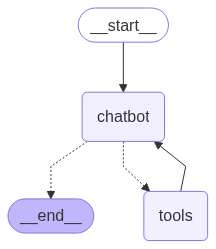

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [8]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: What do you know about LangGraph?
Assistant: [{'type': 'text', 'text': 'Here is what I could find about LangGraph:'}, {'type': 'tool_use', 'name': 'tavily_search', 'input': {'query': 'LangGraph', 'search_depth': 'advanced'}, 'id': 'tooluse_R4sCTMTzSh6u-wgTWzWhPg'}]
Assistant: {"query": "LangGraph", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.ibm.com/think/topics/langgraph", "title": "What is LangGraph? - IBM", "content": "LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. It provides a set of tools and libraries that enable users to create, run and optimize large language models (LLMs) in a scalable and efficient manner. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. [...] Agent systems: LangGraph provides a framework for